In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import sys
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, classification_report, mean_absolute_error, r2_score

# Import necessary TensorFlow and Keras components
from tensorflow.keras.optimizers import Adamax, Adagrad, SGD, RMSprop
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPool1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import utils
import itertools

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/last_team_project/imputed_knn_household_power_cons_3.csv') ## importing already imputed dataset

In [ ]:
df ## checking our dataset

,dt,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...,...
2075254,2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2075255,2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2075256,2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0
2075257,2010-11-26 21:01:00,0.934,0.000,239.70,3.8,0.0,0.0,0.0


In [ ]:
## converting the column in the DataFrame to a pandas DateTime index.
df['dt'] = pd.to_datetime(df['dt'])
df.set_index('dt', inplace=True)

In [ ]:
df ## getting a glimpse of the DataFrame to display the first few rows

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0


transforming time series data into a supervised learning problem for use in machine learning models and creating a new DataFrame where each row contains a combination of lagged (past) and lead (future) time steps as columns, making it suitable for supervised learning tasks like regression or time series forecasting.

In [ ]:
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):

  n_vars = 1 if type(data) is list else data.shape[1]

  dff = pd.DataFrame(data)

  cols, names = list(), list()

  for i in range(n_in, 0, -1):
    cols.append(dff.shift(i))
    names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]

  for i in range(0, n_out):
    cols.append(dff.shift(- 1))
    if i == 0:
      names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]

  agg = pd.concat(cols, axis = 1)
  agg.columns = names

  if dropnan:
    agg.dropna(inplace = True)
  return agg

In [ ]:
## preparing input and output sequences for training a Long Short-Term Memory (LSTM) model for time series forecasting
def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X.iloc[i:i + window_size,:].values)
        ys.append(y.iloc[i + window_size])
    return np.array(Xs), np.array(ys)

In [ ]:
def train_lstm(X_train, y_train, X_test, y_test, units=100, dropout_rate=0.2, epochs=100, batch_size=100, patience=5, optimizer='adam', verbose=1):

    # Creating the model
    model = Sequential()
    model.add(LSTM(units, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))

    # Compiling the model
    model.compile(loss='mean_squared_error', optimizer=optimizer)

    # Setting up early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, mode='min', verbose=1)

    # Training the model
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        verbose=verbose,
        shuffle=False,
        callbacks=[early_stopping]
    )

    return model, history


In [ ]:
def calculate_rmse(model, X_test, y_test, scaler):
    # Get the model's predictions
    yhat = model.predict(X_test)

    # Reshape the input data for inverse scaling
    test_X = X_test.reshape((X_test.shape[0], X_test.shape[2]))

    # Combine the predictions with the input data for inverse scaling
    inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:, 0]

    # Combine the actual values with the input data for inverse scaling
    test_y = y_test.reshape((len(y_test), 1))
    inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:, 0]

    # Calculate the RMSE
    rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))

    return rmse

In [ ]:
def evaluate_metrics(y_true, y_pred, scaler):
    # Invert scaling
    y_true = y_true.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)

    # Compute inverse scaling
    y_true_inv = y_true * (scaler.data_max_[-1] - scaler.data_min_[-1]) + scaler.data_min_[-1]
    y_pred_inv = y_pred * (scaler.data_max_[-1] - scaler.data_min_[-1]) + scaler.data_min_[-1]

    # Calculate metrics
    mse = mean_squared_error(y_true_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_inv, y_pred_inv)
    r2 = r2_score(y_true_inv, y_pred_inv)

    # Print metrics
    print('MSE: {:.2f}'.format(mse))
    print('RMSE: {:.2f}'.format(rmse))
    print('MAE: {:.2f}'.format(mae))

In [ ]:
## function to evaluate all models results in the end
def evaluate_lstm_models(models, X_test_data, y_test_data, scaler):
    for model_name, model in models.items():
        print(f'Model "{model_name}" metrics:')
        print(f"Results for {model_name}:")

        y_pred = model.predict(X_test_data)
        metrics = evaluate_metrics(y_test_data, y_pred, scaler)

In [ ]:
## resampling the DataFrame at hourly frequency, calculating the mean of each hourly interval.
df_resample = df.resample('h').mean()

df_resample.shape

(34589, 7)

In [ ]:
df_resample ## checking resampled data

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667
...,...,...,...,...,...,...,...
2010-11-26 17:00:00,1.725900,0.061400,237.069667,7.216667,0.0,0.000000,12.866667
2010-11-26 18:00:00,1.573467,0.053700,237.531833,6.620000,0.0,0.000000,0.000000
2010-11-26 19:00:00,1.659333,0.060033,236.741000,7.056667,0.0,0.066667,0.000000


In [ ]:
## performing scaling on the resampled DataFrame
values = df_resample.values

scaler = MinMaxScaler(feature_range = (0, 1))
scaled = scaler.fit_transform(values)

scaled

array([[0.63681623, 0.29573827, 0.33794529, ..., 0.        , 0.01136636,
        0.78241815],
       [0.54504495, 0.10335773, 0.33550078, ..., 0.        , 0.14465183,
        0.78267595],
       [0.50900588, 0.11007318, 0.28380167, ..., 0.        , 0.03086863,
        0.7741686 ],
       ...,
       [0.2385342 , 0.07752906, 0.41839455, ..., 0.        , 0.00143575,
        0.        ],
       [0.16153105, 0.07899268, 0.52024552, ..., 0.        , 0.022972  ,
        0.        ],
       [0.12594772, 0.        , 0.53152393, ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
## performing a time series to supervised learning transformation using the series_to_supervised function
reframed = series_to_supervised(scaled)
reframed.drop(reframed.columns[[8, 9, 10, 11, 12, 13]], axis = 1, inplace = True)

reframed.head(10)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
1,0.636816,0.295738,0.337945,0.631157,0.0,0.011366,0.782418,0.509006
2,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676,0.488550
3,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.774169,0.455597
4,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.778809,0.322555
5,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917,0.301032
6,0.322555,0.072536,0.495847,0.323529,0.0,0.002872,0.205723,0.273201
7,0.301032,0.092251,0.567188,0.301052,0.0,0.001795,0.000000,0.501108
8,0.273201,0.132286,0.580314,0.273434,0.0,0.010050,0.000000,0.227338
9,0.501108,0.176840,0.560615,0.492946,0.0,0.543431,0.000000,0.238980
10,0.227338,0.101033,0.766632,0.228360,0.0,0.012204,0.000000,0.324983


In [ ]:
# Split data into train and test sets
train_size = int(len(reframed) * 0.8)
train, test = reframed.iloc[:train_size,:], reframed.iloc[train_size:,:]

In [ ]:
window_size = 1 ##  the variable window_size typically refers to the number of lagged time steps used as input to predict the next time step

In [ ]:
# Create input and output sequences for train and test sets
X_train, y_train = create_sequences(train.iloc[:,:-1], train.iloc[:,-1], window_size)
X_test, y_test = create_sequences(test.iloc[:,:-1], test.iloc[:,-1], window_size)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape ## checking the shapes

((27668, 1, 7), (6917, 1, 7), (27668,), (6917,))

## Model Training

In [ ]:
model_Adam, history_Adam = train_lstm(X_train,
                                      y_train,
                                      X_test,
                                      y_test,
                                      units=50,
                                      dropout_rate=0.5,
                                      epochs=200,
                                      batch_size=64,
                                      patience=10,
                                      optimizer='adam',
                                      verbose=1) ## training model using Adam optimizer

Epoch 1/200
433/433 [==============================] - 10s 6ms/step - loss: 0.0215 - val_loss: 0.0143
Epoch 2/200
433/433 [==============================] - 2s 5ms/step - loss: 0.0189 - val_loss: 0.0150
Epoch 3/200
433/433 [==============================] - 2s 5ms/step - loss: 0.0187 - val_loss: 0.0152
Epoch 4/200
433/433 [==============================] - 2s 4ms/step - loss: 0.0187 - val_loss: 0.0155
Epoch 5/200
433/433 [==============================] - 2s 6ms/step - loss: 0.0187 - val_loss: 0.0155
Epoch 6/200
433/433 [==============================] - 2s 6ms/step - loss: 0.0188 - val_loss: 0.0150
Epoch 7/200
433/433 [==============================] - 2s 5ms/step - loss: 0.0188 - val_loss: 0.0147
Epoch 8/200
433/433 [==============================] - 2s 5ms/step - loss: 0.0189 - val_loss: 0.0144
Epoch 9/200
433/433 [==============================] - 2s 4ms/step - loss: 0.0190 - val_loss: 0.0142
Epoch 10/200
433/433 [==============================] - 2s 5ms/step - loss: 0.0190 - val_l

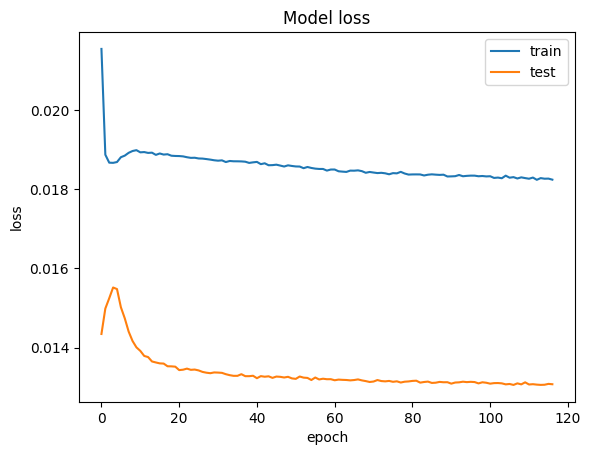

In [ ]:
## plotting the training and validation loss values obtained during the training of the LSTM model using the Adam optimizer.
plt.plot(history_Adam.history['loss'])
plt.plot(history_Adam.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

In [ ]:
# Generate predictions on the test set
y_pred_Adam = model_Adam.predict(X_test)

# Evaluate metrics
evaluate_metrics(y_test, y_pred_Adam, scaler)


217/217 [==============================] - 1s 2ms/step
MSE: 6.07
RMSE: 2.46
MAE: 2.08


## SGD

In [ ]:
model_SGD, history_SGD = train_lstm(X_train,
                                    y_train,
                                    X_test,
                                    y_test,
                                    units=50,
                                    dropout_rate=0.5,
                                    epochs=200,
                                    batch_size=64,
                                    patience=10,
                                    optimizer='SGD',
                                    verbose=1) ## training model using SGD optimizer

Epoch 1/200
433/433 [==============================] - 5s 8ms/step - loss: 0.0219 - val_loss: 0.0131
Epoch 2/200
433/433 [==============================] - 2s 5ms/step - loss: 0.0203 - val_loss: 0.0131
Epoch 3/200
433/433 [==============================] - 2s 4ms/step - loss: 0.0201 - val_loss: 0.0130
Epoch 4/200
433/433 [==============================] - 2s 4ms/step - loss: 0.0201 - val_loss: 0.0130
Epoch 5/200
433/433 [==============================] - 2s 4ms/step - loss: 0.0200 - val_loss: 0.0130
Epoch 6/200
433/433 [==============================] - 2s 4ms/step - loss: 0.0200 - val_loss: 0.0129
Epoch 7/200
433/433 [==============================] - 2s 5ms/step - loss: 0.0199 - val_loss: 0.0129
Epoch 8/200
433/433 [==============================] - 3s 6ms/step - loss: 0.0199 - val_loss: 0.0128
Epoch 9/200
433/433 [==============================] - 2s 4ms/step - loss: 0.0198 - val_loss: 0.0129
Epoch 10/200
433/433 [==============================] - 2s 4ms/step - loss: 0.0198 - val_lo

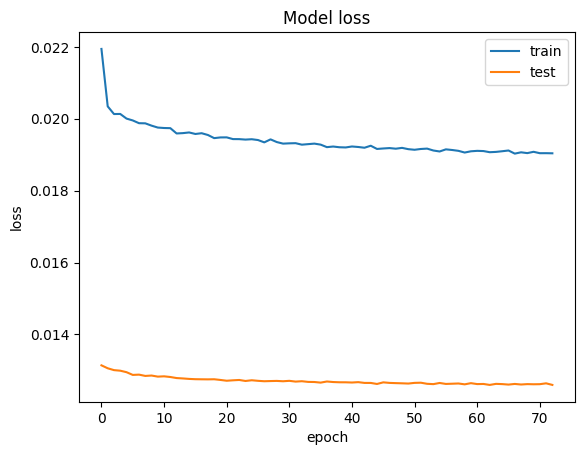

In [ ]:
## plotting the training and validation loss values obtained during the training of the LSTM model using the SGD optimizer.
plt.plot(history_SGD.history['loss'])
plt.plot(history_SGD.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

In [ ]:
# Generate predictions on the test set
y_pred_SGD = model_SGD.predict(X_test)

# Evaluate metrics
evaluate_metrics(y_test, y_pred_SGD, scaler)

217/217 [==============================] - 1s 3ms/step
MSE: 5.85
RMSE: 2.42
MAE: 2.01


## RMSprop

In [ ]:
model_RMSprop, history_RMSprop = train_lstm(X_train,
                                            y_train,
                                            X_test,
                                            y_test,
                                            units = 100,
                                            dropout_rate=0.2,
                                            epochs=200,
                                            batch_size = 100,
                                            patience = 5,
                                            optimizer='RMSprop',
                                            verbose=1) ## training model using RMSprop optimizer

Epoch 1/200
277/277 [==============================] - 4s 6ms/step - loss: 0.0198 - val_loss: 0.0154
Epoch 2/200
277/277 [==============================] - 1s 4ms/step - loss: 0.0180 - val_loss: 0.0158
Epoch 3/200
277/277 [==============================] - 1s 5ms/step - loss: 0.0179 - val_loss: 0.0161
Epoch 4/200
277/277 [==============================] - 1s 4ms/step - loss: 0.0179 - val_loss: 0.0163
Epoch 5/200
277/277 [==============================] - 1s 5ms/step - loss: 0.0179 - val_loss: 0.0162
Epoch 6/200
277/277 [==============================] - 1s 5ms/step - loss: 0.0179 - val_loss: 0.0165
Epoch 6: early stopping


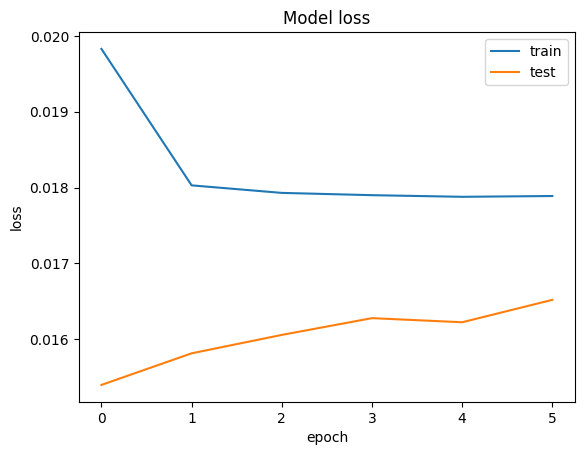

In [ ]:
## plotting the training and validation loss values obtained during the training of the LSTM model using the RMSprop optimizer.
plt.plot(history_RMSprop.history['loss'])
plt.plot(history_RMSprop.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

In [ ]:
# Generate predictions on the test set
y_pred_RMSprop = model_RMSprop.predict(X_test)

# Evaluate metrics
evaluate_metrics(y_test, y_pred_RMSprop, scaler)

217/217 [==============================] - 1s 3ms/step
MSE: 7.67
RMSE: 2.77
MAE: 2.38


## Nesterov accelerated gradient with Momentum

 NAG is a modification of the traditional SGD optimizer that improves convergence speed and stability by incorporating momentum.

In [ ]:
nag = SGD(learning_rate = 0.05, momentum = 0.3, nesterov=True) ## instance of the Stochastic Gradient Descent (SGD) optimizer with Nesterov momentum.

In [ ]:
model_nag, history_nag = train_lstm(X_train,
                                    y_train,
                                    X_test,
                                    y_test,
                                    units = 100,
                                    dropout_rate=0.2,
                                    epochs=200,
                                    batch_size = 100,
                                    patience = 5,
                                    optimizer = nag,
                                    verbose=1) ## using the Nesterov Accelerated Gradient (NAG) optimizer to train an LSTM model for time series forecasting

Epoch 1/200
277/277 [==============================] - 4s 6ms/step - loss: 0.0198 - val_loss: 0.0161
Epoch 2/200
277/277 [==============================] - 1s 4ms/step - loss: 0.0188 - val_loss: 0.0158
Epoch 3/200
277/277 [==============================] - 1s 4ms/step - loss: 0.0186 - val_loss: 0.0157
Epoch 4/200
277/277 [==============================] - 1s 5ms/step - loss: 0.0185 - val_loss: 0.0157
Epoch 5/200
277/277 [==============================] - 1s 4ms/step - loss: 0.0184 - val_loss: 0.0156
Epoch 6/200
277/277 [==============================] - 1s 5ms/step - loss: 0.0183 - val_loss: 0.0157
Epoch 7/200
277/277 [==============================] - 2s 7ms/step - loss: 0.0183 - val_loss: 0.0158
Epoch 8/200
277/277 [==============================] - 2s 6ms/step - loss: 0.0182 - val_loss: 0.0158
Epoch 9/200
277/277 [==============================] - 1s 4ms/step - loss: 0.0182 - val_loss: 0.0158
Epoch 10/200
277/277 [==============================] - 1s 4ms/step - loss: 0.0181 - val_lo

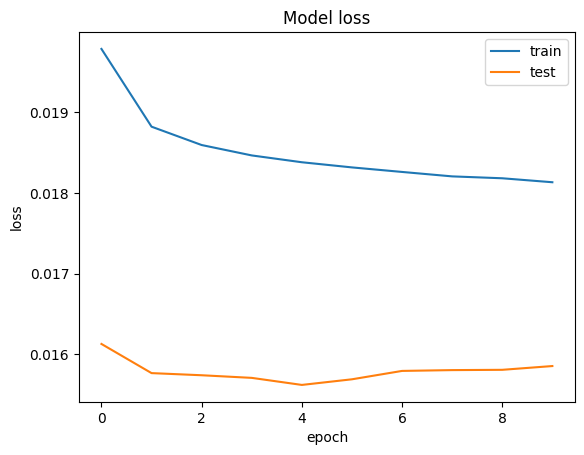

In [ ]:
## plotting the training and validation loss values obtained during the training of the LSTM model using the NAG optimizer.
plt.plot(history_nag.history['loss'])
plt.plot(history_nag.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

In this case early stopping worked out pretty well, and I did not have to wait for so long as I ran other models.

In [ ]:
# Generating predictions on the test set
y_pred_nag = model_nag.predict(X_test)

# Evaluating metrics
evaluate_metrics(y_test, y_pred_nag, scaler)

217/217 [==============================] - 1s 2ms/step
MSE: 7.36
RMSE: 2.71
MAE: 2.33


## Adamax

In [ ]:
model_adamax, history_adamax = train_lstm(X_train,
                                          y_train,
                                          X_test,
                                          y_test,
                                          units = 100,
                                          dropout_rate=0.2,
                                          epochs=200,
                                          batch_size = 100,
                                          patience = 5,
                                          optimizer = 'adamax',
                                          verbose=1) ## training LSTM model using Adamax optimizer

Epoch 1/200
277/277 [==============================] - 4s 7ms/step - loss: 0.0218 - val_loss: 0.0125
Epoch 2/200
277/277 [==============================] - 1s 5ms/step - loss: 0.0199 - val_loss: 0.0129
Epoch 3/200
277/277 [==============================] - 2s 6ms/step - loss: 0.0197 - val_loss: 0.0133
Epoch 4/200
277/277 [==============================] - 2s 7ms/step - loss: 0.0195 - val_loss: 0.0134
Epoch 5/200
277/277 [==============================] - 2s 6ms/step - loss: 0.0194 - val_loss: 0.0132
Epoch 6/200
277/277 [==============================] - 1s 5ms/step - loss: 0.0193 - val_loss: 0.0132
Epoch 6: early stopping


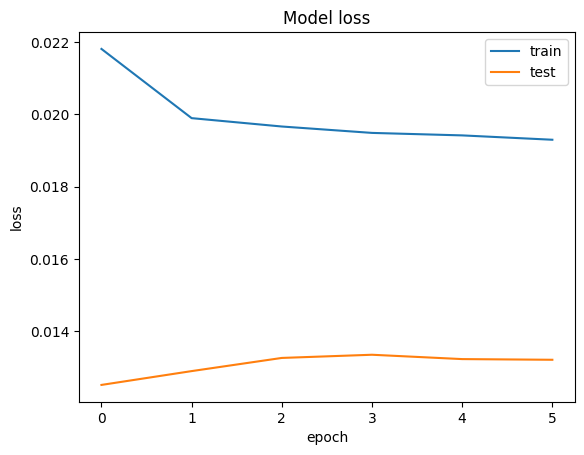

In [ ]:
## plotting the training and validation loss values obtained during the training of the LSTM model using the Adamax optimizer.
plt.plot(history_adamax.history['loss'])
plt.plot(history_adamax.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

In [ ]:
# Generate predictions on the test set
y_pred_adamax = model_adamax.predict(X_test)

# Evaluate metrics
evaluate_metrics(y_test, y_pred_adamax, scaler)

217/217 [==============================] - 1s 2ms/step
MSE: 6.14
RMSE: 2.48
MAE: 2.08


## Adagrad

In [ ]:
model_adagrad, history_adagrad = train_lstm(X_train,
                                            y_train,
                                            X_test,
                                            y_test,
                                            units = 100,
                                            dropout_rate=0.2,
                                            epochs=200,
                                            batch_size = 100,
                                            patience = 5,
                                            optimizer = 'adagrad',
                                            verbose=1) ## training LSTM model using Adagrad optimizer

Epoch 1/200
277/277 [==============================] - 4s 6ms/step - loss: 0.0406 - val_loss: 0.0218
Epoch 2/200
277/277 [==============================] - 1s 5ms/step - loss: 0.0294 - val_loss: 0.0162
Epoch 3/200
277/277 [==============================] - 1s 5ms/step - loss: 0.0248 - val_loss: 0.0139
Epoch 4/200
277/277 [==============================] - 2s 6ms/step - loss: 0.0226 - val_loss: 0.0130
Epoch 5/200
277/277 [==============================] - 2s 6ms/step - loss: 0.0215 - val_loss: 0.0126
Epoch 6/200
277/277 [==============================] - 1s 5ms/step - loss: 0.0210 - val_loss: 0.0125
Epoch 7/200
277/277 [==============================] - 1s 4ms/step - loss: 0.0207 - val_loss: 0.0125
Epoch 8/200
277/277 [==============================] - 1s 4ms/step - loss: 0.0205 - val_loss: 0.0125
Epoch 9/200
277/277 [==============================] - 1s 4ms/step - loss: 0.0204 - val_loss: 0.0125
Epoch 10/200
277/277 [==============================] - 1s 5ms/step - loss: 0.0204 - val_lo

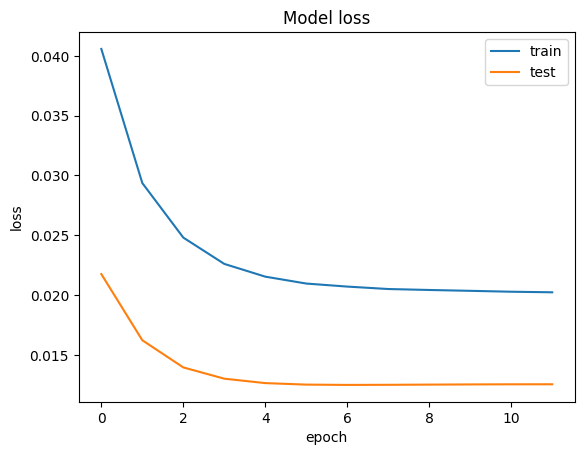

In [ ]:
## plotting the training and validation loss values obtained during the training of the LSTM model using the Adagrad optimizer.
plt.plot(history_adagrad.history['loss'])
plt.plot(history_adagrad.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

In [ ]:
# Generate predictions on the test set
y_pred_adagrad = model_adagrad.predict(X_test)

# Evaluate metrics
evaluate_metrics(y_test, y_pred_adagrad, scaler)

217/217 [==============================] - 1s 2ms/step
MSE: 5.82
RMSE: 2.41
MAE: 2.00


In [ ]:
# listing models
lstm_models = {
    "Adam": model_Adam,
    "SGD": model_SGD,
    "RMSprop": model_RMSprop,
    "Nesterov": model_nag,
    "Adamax": model_adamax,
    "Adagrad": model_adagrad,
}

for model_name, model in lstm_models.items():
    print(f'Model "{model_name}" metrics:')
    print(f"Results for {model_name}:")

    y_pred = model.predict(X_test)
    metrics = evaluate_metrics(y_test, y_pred, scaler)

Model "Adam" metrics:
Results for Adam:
217/217 [==============================] - 0s 2ms/step
MSE: 6.07
RMSE: 2.46
MAE: 2.08
Model "SGD" metrics:
Results for SGD:
217/217 [==============================] - 0s 2ms/step
MSE: 5.85
RMSE: 2.42
MAE: 2.01
Model "RMSprop" metrics:
Results for RMSprop:
217/217 [==============================] - 0s 2ms/step
MSE: 7.67
RMSE: 2.77
MAE: 2.38
Model "Nesterov" metrics:
Results for Nesterov:
217/217 [==============================] - 0s 2ms/step
MSE: 7.36
RMSE: 2.71
MAE: 2.33
Model "Adamax" metrics:
Results for Adamax:
217/217 [==============================] - 0s 2ms/step
MSE: 6.14
RMSE: 2.48
MAE: 2.08
Model "Adagrad" metrics:
Results for Adagrad:
217/217 [==============================] - 0s 2ms/step
MSE: 5.82
RMSE: 2.41
MAE: 2.00


## Resampling to days

In this part of project, I had to resample our data into days as there were too much data when it was resapled hourly. After resampling it to days we can see that our data has gotten much more compact than before.

In [ ]:
df_resample_days = df.resample('D').mean() #resampling data to days to see if the results get better

df_resample_days.shape

(1442, 7)

## Scaling

In [ ]:
## preparing the data for time series forecasting at a daily frequency and applying the RobustScaler to scale the data
### in this part we launched Robust scaler to see the difference between our resampled data
values_days = df_resample_days.values

scaler_days = RobustScaler()
scaled_days = scaler.fit_transform(values_days)

scaled_days

array([[0.91678642, 0.13073198, 0.3153853 , ..., 0.        , 0.16396519,
        0.74035748],
       [0.6942518 , 0.42667057, 0.55049373, ..., 0.18185686, 0.34577587,
        0.53676241],
       [0.43190139, 0.23474981, 0.62051772, ..., 0.09508797, 0.21645057,
        0.5669116 ],
       ...,
       [0.34179083, 0.14708326, 0.54706415, ..., 0.0980399 , 0.23519696,
        0.48701848],
       [0.26107518, 0.0982707 , 0.63914907, ..., 0.09625085, 0.03518044,
        0.16851481],
       [0.31977106, 0.16292032, 0.56297334, ..., 0.11014764, 0.0362503 ,
        0.44982782]])

In [ ]:
## applying the series_to_supervised function to the scaled daily data (scaled_days) to transform it into a supervised learning problem for time series forecasting
reframed_days = series_to_supervised(scaled_days)
reframed_days.drop(reframed_days.columns[[8, 9, 10, 11, 12, 13]], axis = 1, inplace = True)

reframed_days.head(10)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
1,0.916786,0.130732,0.315385,0.928499,0.000000,0.163965,0.740357,0.431901
2,0.694252,0.426671,0.550494,0.695226,0.181857,0.345776,0.536762,0.313037
3,0.431901,0.234750,0.620518,0.424618,0.095088,0.216451,0.566912,0.436748
4,0.313037,0.202322,0.667476,0.311508,0.075051,0.627798,0.218615,0.324670
5,0.436748,0.232377,0.686364,0.428075,0.000000,0.218680,0.568916,0.462304
6,0.324670,0.182809,0.608808,0.319591,0.158084,0.216830,0.407300,1.000000
7,0.462304,0.309810,0.617634,0.458753,0.281865,0.028904,0.438343,0.508439
8,1.000000,0.413114,0.553494,1.000000,0.238749,0.035098,0.598441,0.551133
9,0.508439,0.199207,0.648397,0.516810,0.152338,0.419688,0.249521,0.814446
10,0.551133,0.469332,0.753158,0.540344,0.592175,0.162028,0.200713,0.282652


In [ ]:
# Split data into train and test sets
train_size_days = int(len(reframed_days) * 0.7)
train_days, test_days = reframed_days.iloc[:train_size_days,:], reframed_days.iloc[train_size_days:,:]

In [ ]:
# Create input and output sequences for train and test sets
X_train_days, y_train_days = create_sequences(train_days.iloc[:,:-1], train_days.iloc[:,-1], window_size)
X_test_days, y_test_days = create_sequences(test_days.iloc[:,:-1], test_days.iloc[:,-1], window_size)

In [ ]:
X_train_days.shape, X_test_days.shape, y_train_days.shape, y_test_days.shape ## checking the shapes

((1006, 1, 7), (432, 1, 7), (1006,), (432,))

## Model training

## Adagrad

In [ ]:
model_adagrad_days, history_adagrad_days = train_lstm(X_train_days,
                                                      y_train_days,
                                                      X_test_days,
                                                      y_test_days,
                                                      units = 100,
                                                      dropout_rate = 0.2,
                                                      epochs = 200,
                                                      batch_size = 100,
                                                      patience = 10,
                                                      optimizer = 'adagrad',
                                                      verbose=1) ## training LSTM model using Adagrad optimizer

Epoch 1/200
11/11 [==============================] - 3s 44ms/step - loss: 0.0911 - val_loss: 0.0815
Epoch 2/200
11/11 [==============================] - 0s 7ms/step - loss: 0.0866 - val_loss: 0.0780
Epoch 3/200
11/11 [==============================] - 0s 9ms/step - loss: 0.0834 - val_loss: 0.0749
Epoch 4/200
11/11 [==============================] - 0s 8ms/step - loss: 0.0806 - val_loss: 0.0721
Epoch 5/200
11/11 [==============================] - 0s 8ms/step - loss: 0.0776 - val_loss: 0.0695
Epoch 6/200
11/11 [==============================] - 0s 7ms/step - loss: 0.0757 - val_loss: 0.0671
Epoch 7/200
11/11 [==============================] - 0s 8ms/step - loss: 0.0733 - val_loss: 0.0649
Epoch 8/200
11/11 [==============================] - 0s 7ms/step - loss: 0.0717 - val_loss: 0.0628
Epoch 9/200
11/11 [==============================] - 0s 7ms/step - loss: 0.0697 - val_loss: 0.0608
Epoch 10/200
11/11 [==============================] - 0s 8ms/step - loss: 0.0676 - val_loss: 0.0589
Epoch 11

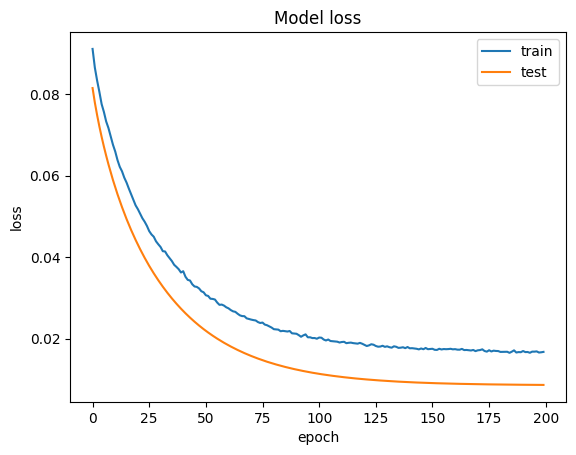

In [ ]:
## ## plotting the training and validation loss values obtained during the training of the LSTM model using the Adagrad optimizer.
plt.plot(history_adagrad_days.history['loss'])
plt.plot(history_adagrad_days.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

In [ ]:
# Generate predictions on the test set
y_pred_adagrad_days = model_adagrad_days.predict(X_test_days)

# Evaluate metrics
evaluate_metrics(y_test_days, y_pred_adagrad_days, scaler)

14/14 [==============================] - 1s 3ms/step
MSE: 2.09
RMSE: 1.45
MAE: 1.12


## SGD

In [ ]:
model_SGD_days, history_SGD_days = train_lstm(X_train_days,
                                              y_train_days,
                                              X_test_days,
                                              y_test_days,
                                              units=50,
                                              dropout_rate=0.5,
                                              epochs=400,
                                              batch_size = 200,
                                              patience = 20,
                                              optimizer='SGD',
                                              verbose=1) ## training LSTM model using SGD optimizer

Epoch 1/400
6/6 [==============================] - 2s 92ms/step - loss: 0.1040 - val_loss: 0.0824
Epoch 2/400
6/6 [==============================] - 0s 12ms/step - loss: 0.0813 - val_loss: 0.0645
Epoch 3/400
6/6 [==============================] - 0s 13ms/step - loss: 0.0664 - val_loss: 0.0508
Epoch 4/400
6/6 [==============================] - 0s 12ms/step - loss: 0.0543 - val_loss: 0.0407
Epoch 5/400
6/6 [==============================] - 0s 10ms/step - loss: 0.0461 - val_loss: 0.0332
Epoch 6/400
6/6 [==============================] - 0s 9ms/step - loss: 0.0392 - val_loss: 0.0276
Epoch 7/400
6/6 [==============================] - 0s 13ms/step - loss: 0.0343 - val_loss: 0.0234
Epoch 8/400
6/6 [==============================] - 0s 13ms/step - loss: 0.0306 - val_loss: 0.0202
Epoch 9/400
6/6 [==============================] - 0s 10ms/step - loss: 0.0280 - val_loss: 0.0178
Epoch 10/400
6/6 [==============================] - 0s 9ms/step - loss: 0.0260 - val_loss: 0.0162
Epoch 11/400
6/6 [===

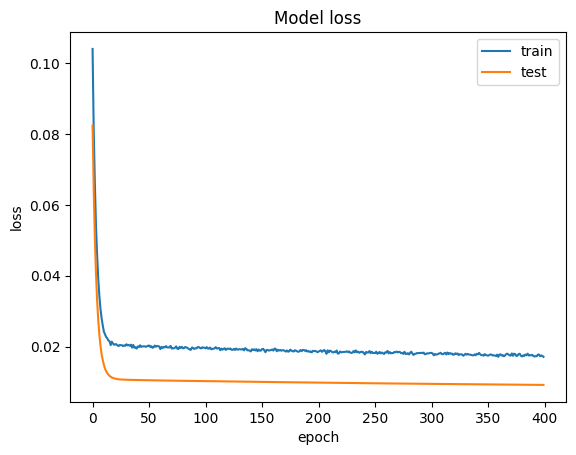

In [ ]:
## plotting the training and validation loss values obtained during the training of the LSTM model using the SGD optimizer.
plt.plot(history_SGD_days.history['loss'])
plt.plot(history_SGD_days.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

In [ ]:
# Generate predictions on the test set
y_pred_SGD_days = model_SGD_days.predict(X_test_days)

# Evaluate metrics
evaluate_metrics(y_test_days, y_pred_SGD_days, scaler)

14/14 [==============================] - 0s 2ms/step
MSE: 2.23
RMSE: 1.49
MAE: 1.15


## RMSprop

In [ ]:
model_RMSprop_days, history_RMSprop_days = train_lstm(X_train_days,
                                            y_train_days,
                                            X_test_days,
                                            y_test_days,
                                            units = 100,
                                            dropout_rate=0.2,
                                            epochs=200,
                                            batch_size = 100,
                                            patience = 5,
                                            optimizer = 'RMSprop',
                                            verbose = 1) ## training LSTM model using RMSprop optimizer

Epoch 1/200
11/11 [==============================] - 2s 49ms/step - loss: 0.0628 - val_loss: 0.0211
Epoch 2/200
11/11 [==============================] - 0s 8ms/step - loss: 0.0251 - val_loss: 0.0098
Epoch 3/200
11/11 [==============================] - 0s 8ms/step - loss: 0.0182 - val_loss: 0.0086
Epoch 4/200
11/11 [==============================] - 0s 7ms/step - loss: 0.0169 - val_loss: 0.0084
Epoch 5/200
11/11 [==============================] - 0s 7ms/step - loss: 0.0167 - val_loss: 0.0083
Epoch 6/200
11/11 [==============================] - 0s 7ms/step - loss: 0.0163 - val_loss: 0.0082
Epoch 7/200
11/11 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0081
Epoch 8/200
11/11 [==============================] - 0s 8ms/step - loss: 0.0157 - val_loss: 0.0080
Epoch 9/200
11/11 [==============================] - 0s 8ms/step - loss: 0.0156 - val_loss: 0.0080
Epoch 10/200
11/11 [==============================] - 0s 8ms/step - loss: 0.0152 - val_loss: 0.0079
Epoch 11

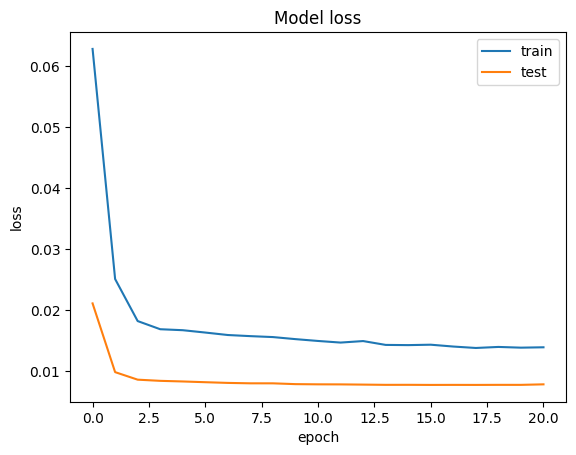

In [ ]:
## plotting the training and validation loss values obtained during the training of the LSTM model using the RMSprop optimizer.
plt.plot(history_RMSprop_days.history['loss'])
plt.plot(history_RMSprop_days.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

In [ ]:
# Generate predictions on the test set
y_pred_RMSprop_days = model_RMSprop_days.predict(X_test_days)

# Evaluate metrics
evaluate_metrics(y_test_days, y_pred_RMSprop_days, scaler)

14/14 [==============================] - 0s 2ms/step
MSE: 1.90
RMSE: 1.38
MAE: 1.06


## Nesterov accelerated gradient with momentum

In [ ]:
nag_days = SGD(learning_rate = 0.01, momentum = 0.9, nesterov=True) ## instance of the Stochastic Gradient Descent (SGD) optimizer with Nesterov momentum. Setting up parameters

In [ ]:
model_nag_days, history_nag_days = train_lstm(X_train_days,
                                              y_train_days,
                                              X_test_days,
                                              y_test_days,
                                              units = 100,
                                              dropout_rate=0.2,
                                              epochs=200,
                                              batch_size = 100,
                                              patience = 5,
                                              optimizer = nag_days,
                                              verbose=1) ## training LSTM model using NAG optimizer

Epoch 1/200
11/11 [==============================] - 3s 69ms/step - loss: 0.0733 - val_loss: 0.0119
Epoch 2/200
11/11 [==============================] - 0s 11ms/step - loss: 0.0269 - val_loss: 0.0158
Epoch 3/200
11/11 [==============================] - 0s 10ms/step - loss: 0.0226 - val_loss: 0.0112
Epoch 4/200
11/11 [==============================] - 0s 11ms/step - loss: 0.0210 - val_loss: 0.0116
Epoch 5/200
11/11 [==============================] - 0s 11ms/step - loss: 0.0211 - val_loss: 0.0108
Epoch 6/200
11/11 [==============================] - 0s 11ms/step - loss: 0.0204 - val_loss: 0.0107
Epoch 7/200
11/11 [==============================] - 0s 11ms/step - loss: 0.0202 - val_loss: 0.0106
Epoch 8/200
11/11 [==============================] - 0s 9ms/step - loss: 0.0201 - val_loss: 0.0105
Epoch 9/200
11/11 [==============================] - 0s 7ms/step - loss: 0.0198 - val_loss: 0.0104
Epoch 10/200
11/11 [==============================] - 0s 9ms/step - loss: 0.0197 - val_loss: 0.0103
Ep

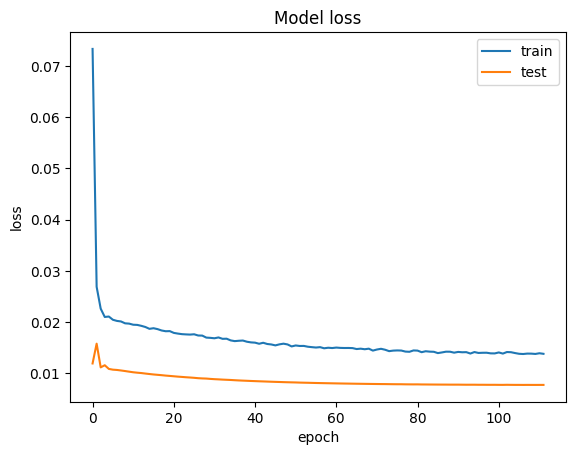

In [ ]:
## plotting the training and validation loss values obtained during the training of the LSTM model using the NAG optimizer.
plt.plot(history_nag_days.history['loss'])
plt.plot(history_nag_days.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

In [ ]:
# Generate predictions on the test set
y_pred_nag_days = model_nag_days.predict(X_test_days)

# Evaluate metrics
evaluate_metrics(y_test_days, y_pred_nag_days, scaler)

14/14 [==============================] - 0s 2ms/step
MSE: 1.88
RMSE: 1.37
MAE: 1.05


## Adam

In [ ]:
model_Adam_days, history_Adam_days = train_lstm(X_train_days,
                                                y_train_days,
                                                X_test_days,
                                                y_test_days,
                                                units=50,
                                                dropout_rate=0.5,
                                                epochs=400,
                                                batch_size = 200,
                                                patience = 20,
                                                optimizer='adam',
                                                verbose=1) ## training LSTM model using Adam optimizer

Epoch 1/400
6/6 [==============================] - 2s 92ms/step - loss: 0.0644 - val_loss: 0.0397
Epoch 2/400
6/6 [==============================] - 0s 13ms/step - loss: 0.0470 - val_loss: 0.0239
Epoch 3/400
6/6 [==============================] - 0s 13ms/step - loss: 0.0325 - val_loss: 0.0141
Epoch 4/400
6/6 [==============================] - 0s 13ms/step - loss: 0.0250 - val_loss: 0.0098
Epoch 5/400
6/6 [==============================] - 0s 12ms/step - loss: 0.0211 - val_loss: 0.0090
Epoch 6/400
6/6 [==============================] - 0s 10ms/step - loss: 0.0205 - val_loss: 0.0092
Epoch 7/400
6/6 [==============================] - 0s 17ms/step - loss: 0.0200 - val_loss: 0.0092
Epoch 8/400
6/6 [==============================] - 0s 17ms/step - loss: 0.0200 - val_loss: 0.0090
Epoch 9/400
6/6 [==============================] - 0s 17ms/step - loss: 0.0191 - val_loss: 0.0088
Epoch 10/400
6/6 [==============================] - 0s 15ms/step - loss: 0.0194 - val_loss: 0.0086
Epoch 11/400
6/6 [=

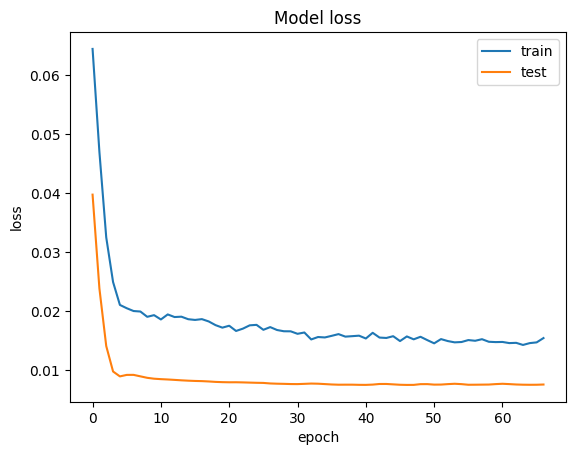

In [ ]:
## plotting the training and validation loss values obtained during the training of the LSTM model using the Adam optimizer.
plt.plot(history_Adam_days.history['loss'])
plt.plot(history_Adam_days.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

In [ ]:
# Generate predictions on the test set
y_pred_Adam_days = model_Adam_days.predict(X_test_days)

# Evaluate metrics
evaluate_metrics(y_test_days, y_pred_Adam_days, scaler)

14/14 [==============================] - 0s 2ms/step
MSE: 1.85
RMSE: 1.36
MAE: 1.05


In [ ]:
lstm_models_days = {
    "Adam_resmapled_days": model_Adam_days,
    "SGD_resampled_days": model_SGD_days,
    "RMSprop_resampled_days": model_RMSprop_days,
    "Nesterov_resampled_days": model_nag_days,
    #"adamax": model_adamax_days,
    "adagrad_resampled_days": model_adagrad_days,
}


lstm_models_hours = {
    "Adam_resampled_hours": model_Adam,
    "SGD_resampled_hours": model_SGD,
    "RMSprop_resampled_hours": model_RMSprop,
    "Nesterov_resampled_hours": model_nag,
    "Adamax_resampled_hours": model_adamax,
    "Adagrad_resampled_hours": model_adagrad
}


evaluate_lstm_models(lstm_models_days, X_test_days, y_test_days, scaler)
evaluate_lstm_models(lstm_models_hours, X_test, y_test, scaler)

Model "Adam_resmapled_days" metrics:
Results for Adam_resmapled_days:
14/14 [==============================] - 0s 4ms/step
MSE: 1.85
RMSE: 1.36
MAE: 1.05
Model "SGD_resampled_days" metrics:
Results for SGD_resampled_days:
14/14 [==============================] - 0s 2ms/step
MSE: 2.23
RMSE: 1.49
MAE: 1.15
Model "RMSprop_resampled_days" metrics:
Results for RMSprop_resampled_days:
14/14 [==============================] - 0s 2ms/step
MSE: 1.90
RMSE: 1.38
MAE: 1.06
Model "Nesterov_resampled_days" metrics:
Results for Nesterov_resampled_days:
14/14 [==============================] - 0s 2ms/step
MSE: 1.88
RMSE: 1.37
MAE: 1.05
Model "adagrad_resampled_days" metrics:
Results for adagrad_resampled_days:
14/14 [==============================] - 0s 2ms/step
MSE: 2.09
RMSE: 1.45
MAE: 1.12
Model "Adam_resampled_hours" metrics:
Results for Adam_resampled_hours:
217/217 [==============================] - 0s 2ms/step
MSE: 3.18
RMSE: 1.78
MAE: 1.50
Model "SGD_resampled_hours" metrics:
Results for SGD_r

## Conclusion

1) After resampling data into days it could be said that MAE, RMSE, MSE scores were lower than it was with resampled data into hours.  
2) As initial 'csv' file is consisted of over 2 millions of observations, despite the percentage of missing values were just around 1 percent it was quite huge number indeed. Moreover, while using imputation methods like KNN(which are considered as quite time consuming), it's better to use faster methods such as IterativeImputer.                                                
3) Feature selection methods were used, but as there are only 7 features. It was hard to decide which one to use, as 3 methods of feature selection was used and all of them came up with different results, and as it is dataset with timesteps I considered that all variables can be important.